In [1]:
import pandas as pd
from mikeio.eum import EUMType, ItemInfo
from fmskill.model import ModelResult
from fmskill.observation import TrackObservation
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# Extract track without having observation as dfs0

In [2]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ModelResult(fn, name='HD')
mr.dfs

Dfsu2D
Number of elements: 958
Number of nodes: 570
Projection: LONG/LAT
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Wind speed <Wind speed> (meter per sec)
Time: 67 steps with dt=3600.0s
      2017-10-27 00:00:00 -- 2017-10-29 18:00:00

In [3]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)

In [4]:
o1 = TrackObservation(df, item=2, name='alti')
o1.itemInfo = ItemInfo(EUMType.Surface_Elevation)    # if TrackObservation is created with a df, itemInfo needs to be added manually

In [5]:
mr.add_observation(o1, item=0)

In [6]:
cc = mr.extract()

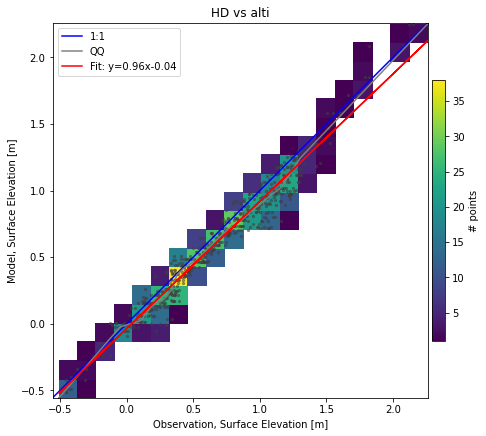

In [7]:
cc['alti'].scatter()

# Extract track from dfs0
ModelResult is now a dfs0

In [8]:
fn = '../tests/testdata/NorthSeaHD_extracted_track.dfs0'
mr = ModelResult(fn, name='HD')
mr.dfs

<mikeio.Dfs0>
Timeaxis: TimeAxisType.NonEquidistantCalendar
Items:
  0:  Longitude <Undefined> (undefined)
  1:  Latitude <Undefined> (undefined)
  2:  Model_surface_elevation <Undefined> (undefined)
  3:  Model_wind_speed <Undefined> (undefined)

In [9]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = TrackObservation(df, item=2, name='alti')

In [10]:
mr.add_observation(o1, item=2)

In [11]:
cc = mr.extract()

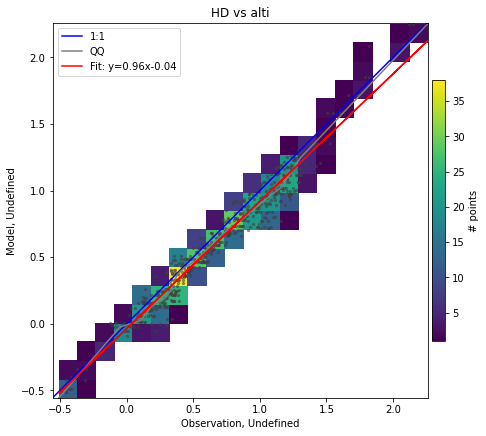

In [12]:
cc['alti'].scatter()

# Big data
Run the download.ipynb first

In [4]:
fn = '../data/SW_gwm_3a_extracted_2018.dfs0'
mr = ModelResult(fn, name='GWM')

<mikeio.Dfs0>
Timeaxis: TimeAxisType.NonEquidistantCalendar
Items:
  0:  LONGITUDE <Latitude longitude> (degree)
  1:  LATITUDE <Latitude longitude> (degree)
  2:  Sign. Wave Height <Significant wave height> (meter)

In [5]:
fn = '../data/altimetry_3a_2018_filter1.dfs0'
o1 = TrackObservation(fn, item=2, name='3a')

In [6]:
mr.add_observation(o1, item=2)

In [7]:
cc = mr.extract()

In [13]:
cc['3a'].skill(end='2018-1-15')

,n,bias,rmse,mape,cc,si,r2
observation,,,,,,,
3a,372356,-0.475229,0.633093,14.747458,0.940399,0.116879,0.968706


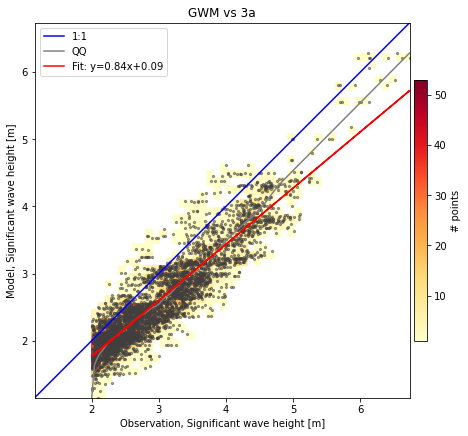

In [22]:
cc['3a'].scatter(end='2018-7-1', area=[0,50,10,60], binsize=0.1, cmap='YlOrRd')

# Spatial binning

In [32]:
import xarray as xr
import numpy as np

In [54]:
df = cc.all_df

In [55]:
df['lonBin'] = pd.cut(df.x,bins=360)
df['latBin'] = pd.cut(df.y,bins=180)

In [56]:
QIs = []
min_observations = 30
for (lonBin,latBin),dfi in df.groupby(['lonBin','latBin']):
    n = len(dfi)
    if n < min_observations:
        continue

    QIi = pd.DataFrame(index=[1],data=dict(N_obs=dfi['obs_val'].count(),mean_obs=dfi['obs_val'].mean(),
        N_mdl=dfi['mod_val'].count(),mean_mdl=dfi['mod_val'].mean()))
    resi =  dfi['obs_val'] - dfi['mod_val']
    
    QIi['n'] = n
    QIi['bias'] = QIi['mean_mdl']-QIi['mean_obs'] 
    QIi['rmse'] = np.sqrt(np.mean(resi**2))
    
    QIi['lon'] = lonBin.mid
    QIi['lat'] = latBin.mid
    QIs.append(QIi.set_index(['lon','lat']))

In [57]:
QI = pd.concat(QIs)
ds = QI.to_xarray()

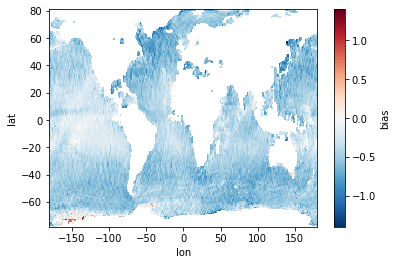

In [58]:
ds['bias'].plot(x='lon',y='lat');

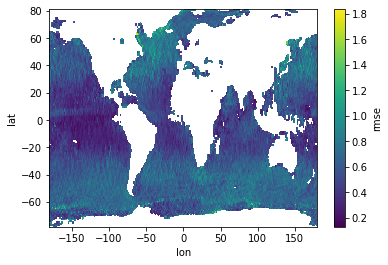

In [59]:
ds['rmse'].plot(x='lon',y='lat');